In [1]:
#style: make functions! even classes if necessary! funcs for FF reduction for example, etc. to reuse for labs 2 and 3!
#say what functions and key(most) lines/line groups do!
#long descriptions can be in the form of comments if about a specific block
#make graph labels BIG!
#move files to the local jupyter directory, avoiding reference to my name or group

## Data Analysis

(intro description)

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output 
import os

### 4.1: Bias Frames (Trevor)

(a description of what I do in 4.1.1 and 4.1.2)

In [2]:
#The following function creates a numpy histogram object given.
#It does so by iterating over the given files, using a context manager 
#and opening each file, reshaping each file to a 1D array, looping over
#this new array, and adding pixel count amounts 1 by 1 to a combining list. 
#The total number of pixels is for the whole camera, not just those being graphed for a given function call.
def fits_list_generate(files): #files is a list of file path strings
    total_pixel_counts_list = []
    for file in files:
        with fits.open(file) as hdu:
            data = hdu[0].data
            data_serialized = np.reshape(data,np.size(data))
            for x in data_serialized:
                total_pixel_counts_list.append(x)
    print(f"The total number of pixels is {len(total_pixel_counts_list)}, \
    since {len(files)} frames have {int(len(total_pixel_counts_list)/len(files))} pixels")
    return total_pixel_counts_list

#A normal distribution, scaled by a constant factor to fit a gaussian distribution 
#to a non-normalized function and still have an easily defined mean and standard 
#deviation.
def scaled_normal_dist(x, a, mean, stdev):
    return a * np.exp(-(x-mean)**2/(2.0*stdev**2)) / np.sqrt(2.0*np.pi*stdev**2)

#graphs the histogram and the gaussian fit for a given pixel counts list, bin number,
#counts range, and creates a bar graph with bars of tunable width (in approximately units of counts, it seems). 
def graph_histogram_gaussian_fit(total_pixel_counts_list,bins,counts_range,width=.8):
    hist = np.histogram(total_pixel_counts_list,bins=bins,range=counts_range)
    hist_x_vals = hist[1][1:] - .5*(hist[1][1]-hist[1][0])
    hist_y_vals= hist[0]
    popt, pcov = curve_fit(scaled_normal_dist, xdata=hist_x_vals, ydata=hist_y_vals, p0=[20,1000,20])
    print(f"Optimal parameters: [a  mean  stdev] = {popt}")
    fig, ax = plt.subplots()
    ax.set_xlabel("Counts",fontsize=20)
    ax.set_ylabel("Frequency",fontsize=20)
    fit_x_vals = np.linspace(hist_x_vals[0],hist_x_vals[-1],300)
    ax.bar(hist_x_vals,hist_y_vals,label='Histogram',width=width)
    ax.plot(fit_x_vals,scaled_normal_dist(fit_x_vals, *popt),'r-',label="Fit")
    ax.legend()

#The three 0C bias fits files
fits_files = ["Documents/Group 2 Data/Photometry/bias_frames_at_different_temperatures/bias_frame_at_0C_.00000010.BIAS.FIT",
              "Documents/Group 2 Data/Photometry/bias_frames_at_different_temperatures/bias_frame_at_0C_.00000011.BIAS.FIT",
              "Documents/Group 2 Data/Photometry/bias_frames_at_different_temperatures/bias_frame_at_0C_.00000012.BIAS.FIT"]

#These values produced a good-looking gaussian fit, where some 
#other combinations would produce much less accurate-seeming results.
graph_histogram_gaussian_fit(fits_list_generate(fits_files),40,[960,1040])

FileNotFoundError: [Errno 2] No such file or directory: 'Documents/Group 2 Data/Photometry/bias_frames_at_different_temperatures/bias_frame_at_0C_.00000010.BIAS.FIT'

The total number of pixels is 3145728,     since 3 frames have 1048576 pixels
Optimal parameters: [a  mean  stdev] = [  20. 1000.   20.]


C:\Users\tdavd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_minpack_py.py:499: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T


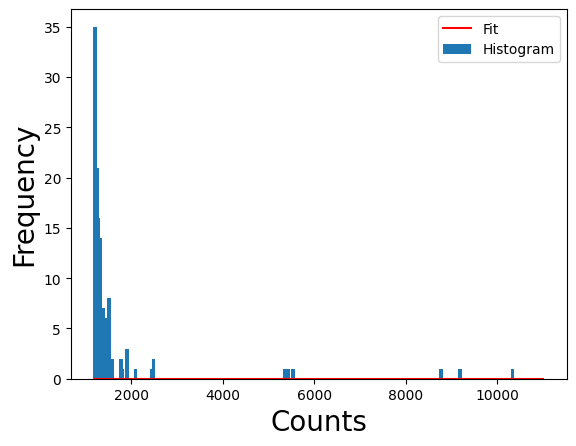

In [4]:
#This block uses the same function as above to search for hot pixels, which is why width and scale are arguments.
#The leftmost spike and its surrounding high density of values is viewed as part of the tail of the Gaussian, with real
#hot pixels only obviously starting around 5000. It is possible that some of the higher pixels on the alleged Gaussian tail
#are warm pixels, but not as obvious. Thus, the cutoff above which pixels are ignored is declared as 5000. Using numpy's
#array methods, it is determined that the rightmost point is the maximum value recorded. Changes to this value can be made to 
#avoid future hot and current warm pixels at the possible expense of some functioning pixels. 
#Note: iven the bounds, we do not expect reasonable parameters; we only want to see pixel counts anyway for this plot.
graph_histogram_gaussian_fit(fits_list_generate(fits_files),300,[1200,11000],width=80)

In [5]:
#From the above, determine fraction of identified hot pixels:
n_hot_pixels = 0
counts_list = fits_list_generate(fits_files)
clear_output() #because we don't need to know how many pixels there are now. It's inelegant and will be fixed later.
for x in counts_list:
    if x > 5000:
        n_hot_pixels += 1
print(f"There are {n_hot_pixels} identified hot pixels, a fraction of {n_hot_pixels/len(counts_list):.7f} of the total.")

There are 6 identified hot pixels, a fraction of 0.0000019 of the total.


In [6]:
#This block prints the headers of one of the bias fits files.
#According to the CCD datasheet, gain = 2., readout noise 14.8e- RMS. Gain agrees to within 3% with header
with fits.open("Documents/Group 2 Data/Photometry/bias_frames_at_different_temperatures/bias_frame_at_0C_.00000010.BIAS.FIT") as hdu:
            print(hdu[0].header)

print('\n', f"The readout noise from our data is {2.06*7.82:.1f} e-, which is {100.*(2.06*7.82-14.8)/(14.8):.2f}% away from the datasheet value.")

SIMPLE  =                    T/CCDSOFT-SOFTWARE BISQUE 3                        BITPIX  =                   16                                                  NAXIS   =                    2                                                  NAXIS1  =                 1024                                                  NAXIS2  =                 1024                                                  BSCALE  = +1.000000000000E+000                                                  BZERO   = +3.276800000000E+004                                                  BIAS    =                  100                                                  FOCALLEN= +0.000000000000E+000                                                  APTAREA = +0.000000000000E+000                                                  APTDIA  = +0.000000000000E+000                                                  DATE-OBS= '2024-08-30T01:57:32.328'                                             TIME-OBS= '01:57:32.328        '        

### 4.2.1 (Anthony)

In [19]:
#This creates a list of all FITS files that will be used.
folder_path = r'C:\Users\antho\OneDrive\PHY 443\lab_1_data\Photometry\dark_frames_at_.3s_exposure'
file_number = 0
file_name = '\dark_0.3s_exposure_.0000000' + str(file_number) + '.DARK.FIT'
file_list = []
num_of_files = 10

i=0
while i < num_of_files:
    file_name = '\dark_0.3s_exposure_.0000000' + str(i) + '.DARK.FIT'
    file_list.append(folder_path + file_name)
    i = i + 1

for file in file_list: print(file) #View file list

C:\Users\antho\OneDrive\PHY 443\lab_1_data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000000.DARK.FIT
C:\Users\antho\OneDrive\PHY 443\lab_1_data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000001.DARK.FIT
C:\Users\antho\OneDrive\PHY 443\lab_1_data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000002.DARK.FIT
C:\Users\antho\OneDrive\PHY 443\lab_1_data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000003.DARK.FIT
C:\Users\antho\OneDrive\PHY 443\lab_1_data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000004.DARK.FIT
C:\Users\antho\OneDrive\PHY 443\lab_1_data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000005.DARK.FIT
C:\Users\antho\OneDrive\PHY 443\lab_1_data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000006.DARK.FIT
C:\Users\antho\OneDrive\PHY 443\lab_1_data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000007.DARK.FIT
C:\Users\antho\OneDrive\PHY 443\lab_1_da

In [24]:
#4.2.1 functions

#A 2d array, one dimension selecting the frame and the other selecting the pixel in that frame?
def fits_data_to_2d_array(file_list):
    columns = []
    for file in file_list:
        with fits.open(file) as hdu:
            data = hdu[0].data
            data_serialized = np.reshape(data,np.size(data))
            columns.append(data_serialized)
    pixel_counts_array = np.column_stack(columns)
    print('pixel_counts_array Shape:',pixel_counts_array.shape)
    print('pixel_counts_array Size:',pixel_counts_array.size)
    return pixel_counts_array
    
    
#The original median combine function. I'll leave it up to Anthony on how to update 4.2.1,
#since it seems this outputs a ~1e6x1 array
def median_combine_og(pixel_counts_array):
    master_dark_frame_array = np.zeros(len(pixel_counts_array))
    for row in range(pixel_counts_array.shape[0]):
        master_dark_frame_array[row] = np.median(pixel_counts_array[row, :]) 
    print('master_dark_frame_array Shape:',master_dark_frame_array.shape)
    print('master_dark_frame_array Size:',master_dark_frame_array.size)
    return master_dark_frame_array

#This function was never used. Can we remove it?
def fits_data_to_1d_array(file_list):  #Actually you can just do    array.flatten()   but which is quicker?
    pixel_counts_array_1d = []
    for file in file_list:
        with fits.open(file) as hdu:
            data = hdu[0].data
            data_serialized = np.reshape(data,np.size(data))
            pixel_counts_array_1d = np.append(pixel_counts_array_1d, data_serialized)
    print('pixel_counts_array_1d Shape:',pixel_counts_array_1d.shape)
    print('pixel_counts_array_1d Size:',pixel_counts_array_1d.size)
    return pixel_counts_array_1d

def hot_pixel_identifier(pixel_counts_array):
    arr_shape = np.shape(pixel_counts_array)
    hot_pixel_array = np.zeros((int(arr_shape[0]), int(arr_shape[1])))
    for (i,j), value in np.ndenumerate(pixel_counts_array):
        if value >= 2000: hot_pixel_array[i,j] = 1         #THRESHOLD!!
    print(np.shape(hot_pixel_array))
    return hot_pixel_array

def hot_pixel_array_sum_rows(hot_pixel_array):
    raw_data_shape = shape_of_raw_data(file_list)
    hot_pixels_1d = np.zeros(len(hot_pixel_array))    
    for row in range(hot_pixel_array.shape[0]): 
        hot_pixels_1d[row] = np.sum(hot_pixel_array[row])
        if hot_pixels_1d[row] > 0: 
            print('Hot pixel in row ', row)
            print('Location:', np.unravel_index(row, raw_data_shape))
    return hot_pixels_1d

def shape_of_raw_data(file_list):  
    for file in file_list:
        with fits.open(file) as hdu:
            data = hdu[0].data
            return(np.shape(data))

In [23]:
#Stores data from images into a 2-dim array:
pixel_counts_array = fits_data_to_2d_array(file_list)
#Performs a median combine to get a master dark frame:
master_dark_frame_array = median_combine_og(pixel_counts_array)

[[1050 1030 1035 ... 1008  998 1005]
 [1042 1018 1042 ... 1004 1004 1003]
 [1035 1025 1022 ...  986  997 1005]
 ...
 [1048 1027 1024 ... 1021 1009 1019]
 [1033 1033 1036 ... 1010 1014  998]
 [1031 1024 1030 ... 1014 1015 1011]]
[[1036 1032 1028 ...  999  991 1007]
 [1055 1018 1025 ...  999 1006  994]
 [1041 1031 1027 ... 1005 1004 1007]
 ...
 [1027 1024 1040 ... 1010 1010 1014]
 [1026 1030 1025 ... 1005 1006 1016]
 [1005 1019 1031 ... 1011 1017 1016]]
[[1041 1032 1027 ... 1003 1001 1001]
 [1041 1033 1032 ... 1007 1005 1010]
 [1034 1024 1033 ... 1005 1008  997]
 ...
 [1024 1037 1013 ... 1001 1008 1016]
 [1021 1035 1022 ... 1009 1007 1014]
 [1035 1034 1030 ... 1024 1013 1010]]
[[1042 1027 1037 ...  990 1012 1001]
 [1051 1030 1030 ...  991 1005 1005]
 [1030 1017 1029 ... 1005 1004 1012]
 ...
 [1029 1035 1031 ... 1008 1030  997]
 [1031 1034 1031 ... 1012 1008 1014]
 [1034 1031 1031 ... 1020 1006 1009]]
[[1046 1033 1036 ... 1002  998 1007]
 [1039 1027 1018 ... 1002 1012  998]
 [1032 1030 10

In [ ]:
#Save to .csv to view manually
np.savetxt("pixel_counts_array.csv", pixel_counts_array, delimiter = ",", fmt='%d')
np.savetxt("master_dark_frame.csv", master_dark_frame_array, delimiter = ",", fmt='%d')

In [ ]:
                                   #Identifying Hot Pixels
#Plot histogram to see distribution:
graph_histogram_gaussian_fit(pixel_counts_array.flatten(),40,[960,1040], width=.5)
#Plot another to see where some hot pixels may be
graph_histogram_gaussian_fit(pixel_counts_array.flatten(),300,[1200,11000],width=80)

In [ ]:
                                   #Identifying Hot Pixels Cont...
#Threshold used: 2000 counts

#The following creates an array (with the same shape as the input) filled with zeros except for the
#pixels that are above the threshhold - they are given a value equal to 1.
hot_pixel_array = hot_pixel_identifier(pixel_counts_array)
np.savetxt("hot_pixel_array.csv", hot_pixel_array, delimiter=",", fmt='%d') #For manual viewing
print('Number of hot pixels: ', np.sum(hot_pixel_array).flatten())

#The following creates an 1d array out of the hot pixels array that stores the sum of each row.
#The purpose of this is to see if the identified hot pixels are "hot" for all images. 
hot_pixel_rows_summed = hot_pixel_array_sum_rows(hot_pixel_array)
print('Number of hot pixels: ', np.sum(hot_pixel_rows_summed)) #Double check sum
np.savetxt("hot_pixel_rows_summed.csv", hot_pixel_rows_summed, delimiter=",", fmt='%d')

In [ ]:
#Gauge Middle Value for Counts, and other statistics
median = np.median(pixel_counts_array)
mean = pixel_counts_array.mean()
minimum = np.min(pixel_counts_array)
maximum = np.max(pixel_counts_array)
print('median: ', median, 'mean: ', mean, 'min: ', minimum, 'max: ', maximum)
max_index = np.argmax(pixel_counts_array)
print(max_index)

## 4.2.2 (Ronan)

In [1]:
# Define folder path and file naming pattern
folder_path = r"C:\Users\ronan\Group 2 Data-20240830T052051Z-001\Group 2 Data\Photometry\dark_frames_at_different_exposure_times"
# Paths to bias frames
bias_frame_paths = [
    r"C:\Users\ronan\Group 2 Data-20240830T052051Z-001\Group 2 Data\Photometry\bias_frames_at_different_temperatures\bias_frame_at_0C_.00000010.BIAS.FIT",
    r"C:\Users\ronan\Group 2 Data-20240830T052051Z-001\Group 2 Data\Photometry\bias_frames_at_different_temperatures\bias_frame_at_0C_.00000011.BIAS.FIT",
    r"C:\Users\ronan\Group 2 Data-20240830T052051Z-001\Group 2 Data\Photometry\bias_frames_at_different_temperatures\bias_frame_at_0C_.00000012.BIAS.FIT"
]
def create_file_list(folder_path):
    files = [f for f in os.listdir(folder_path) if f.startswith('dark_frame_') and f.endswith('.DARK.FIT')]
    file_list = [os.path.join(folder_path, f) for f in files]
    exposure_times = [float(f.split('_')[2].replace('s', '')) for f in files]
    return file_list, exposure_times

Generates a list of filenames in the directory that match the pattern dark_frame_*.DARK.FIT, creates a path, and extracts the exposure times as floats for calculations, and returns file paths and exp times.

In [2]:
#pixel data/conversion
def load_dark_frames(file_list):
    pixel_counts_list = []
    for file in file_list:
        if os.path.isfile(file):
            try:
                with fits.open(file) as hdu:
                    pixel_counts_list.append(hdu[0].data.flatten())
            except Exception as e:
                print(f"Error loading file {file}: {e}")
        else:
            print(f"File not found: {file}")
    return np.array(pixel_counts_list)

Stores pixel data for each dark frame and flattens it into a 1D array and returns them as a Numpy array

In [3]:
# calculates mean count, stdv, and uncertainty
def calculate_statistics(frames):
    means = np.mean(frames, axis=1)
    std_devs = np.std(frames, axis=1)
    uncertainties = std_devs / np.sqrt(frames.shape[1])
    return means, uncertainties

function calculates mean count values of frames per pixel and the associated standard deviation. As well as the uncertainty (statistical) using the stdv and #of frames.

In [4]:
#linear regression calculations
def linear_fit(x, slope, intercept):
    return slope * x + intercept

def perform_linear_regression(x, y, yerr):
    popt, pcov = curve_fit(linear_fit, x, y, sigma=yerr, absolute_sigma=True)
    return popt, np.sqrt(np.diag(pcov))

linear fit defines a function for "fitting" with parameters of x, slope, and intercept. perform_linear_regrssion fits the function to our data using exposure times (x) , mean count (y) , and uncertainties (yerr). Returns optimized parameters and standard error

In [5]:
#plotting 
def plot_mean_vs_exposure(exposure_times, means, uncertainties, slope, intercept):
    plt.errorbar(exposure_times, means, yerr=uncertainties, fmt='o', label='Data')
    plt.plot(exposure_times, linear_fit(np.array(exposure_times), slope, intercept), 'r-', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}')
    plt.xlabel('Exposure Time (s)')
    plt.ylabel('Mean Counts')
    plt.legend()
    plt.show()

def plot_residuals(exposure_times, means, uncertainties, slope, intercept):
    fit_line = linear_fit(np.array(exposure_times), slope, intercept)
    residuals = np.array(means) - fit_line
    plt.errorbar(exposure_times, residuals, yerr=uncertainties, fmt='o', label='Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Exposure Time (s)')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

This cell block contains the plotting of both the relationship between mean counts vs. exposure times as well the residuals (with uncertainties) of data points.

In [6]:
# Function to calculate the mean of bias frames
def calculate_bias_mean(bias_paths):
    bias_means = []
    for path in bias_paths:
        try:
            with fits.open(path) as hdul:
                data = hdul[0].data
                bias_means.append(np.mean(data))
        except Exception as e:
            print(f"Error reading bias frame {path}: {e}")
    # Calculate the overall mean of the bias frames
    overall_bias_mean = np.mean(bias_means)
    print(f"Calculated mean of the bias frames: {overall_bias_mean:.2f}")
    return overall_bias_mean

Cell block calculates the means of the bias frames for subtraction to the dark frames in calculating dark current estimation.

In [7]:
#dark current estimation
def estimate_dark_current(means, exposure_times, gain):
    dark_current = np.mean((np.array(means)-calculate_bias_mean(bias_frame_paths)) / np.array(exposure_times))*gain
    print("averaged dark frame mean", np.array(means)) 
    dark_current_std = np.std((np.array(means)-calculate_bias_mean(bias_frame_paths)) / np.array(exposure_times))
    return dark_current, dark_current_std

calculates average resulting dark current using average of the quotient between mean counts and exposure times.

[1089.87830639 1008.69760799 1106.98442459 1020.00199699 1029.44412804
 1038.41212845 1047.05791283 1056.19071388 1072.58418083] [0.37765927 0.09366332 0.42681165 0.12440165 0.15981561 0.1910704
 0.22605351 0.25996518 0.32007864]


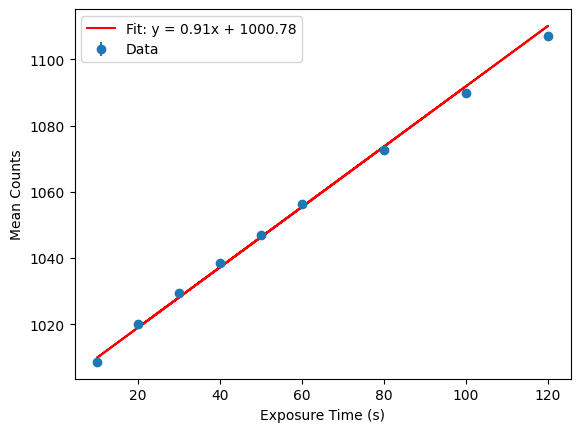

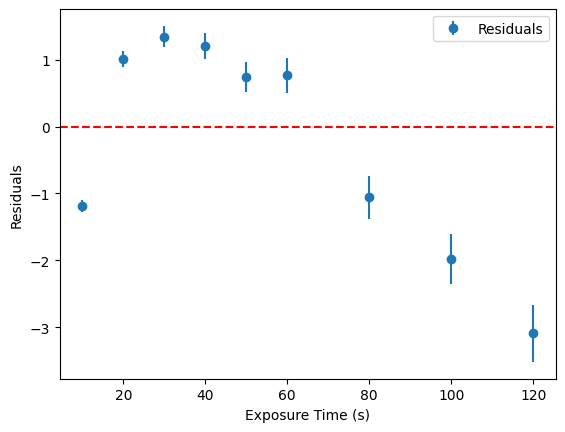

Calculated mean of the bias frames: 1003.60
averaged dark frame mean [1089.87830639 1008.69760799 1106.98442459 1020.00199699 1029.44412804
 1038.41212845 1047.05791283 1056.19071388 1072.58418083]
Calculated mean of the bias frames: 1003.60
Estimated Dark Current: 1.6844585390547147 electrons/pixel/second
Standard Deviation of Dark Current: 0.11115527655193663 electrons/pixel/second


In [12]:
def main():
    file_list, exposure_times = create_file_list(folder_path)
    pixel_counts_array = load_dark_frames(file_list)
    
    if pixel_counts_array.size == 0:
        print("No files were successfully loaded. Please check file paths and file existence.")
        return

    means, uncertainties = calculate_statistics(pixel_counts_array)
    print( means, uncertainties) 
    # Perform linear regression
    (slope, intercept), (slope_err, intercept_err) = perform_linear_regression(exposure_times, means, uncertainties)

    # Plot results
    plot_mean_vs_exposure(exposure_times, means, uncertainties, slope, intercept)
    plot_residuals(exposure_times, means, uncertainties, slope, intercept)

    # Estimate dark current
    gain = 2.05
    avg_dark_current, std_dark_current = estimate_dark_current(means, exposure_times, gain)
    print(f"Estimated Dark Current: {avg_dark_current} electrons/pixel/second")
    print(f"Standard Deviation of Dark Current: {std_dark_current} electrons/pixel/second")

if __name__ == "__main__":
    main()

Main function carries out our calculations calling the defined functions with the appropriate parameters and values, consolidating the processes of calculation. Observed lower residuals the greater our exposure time, as expected as we know that increasing the exposure time generally gives us better results and data. We also observe the expected positvely linear relationship between mean counts of the dark current as well as exposure times. Higher exposure means an increase in Signal-to-ratio which would imply higher counts and therefore dark current.

## 4.3: Flat Frames (Trevor)

(A description of what's going on here. Flat fields are best taken day-of, since conditions vary by the day.)

In [106]:
#Functions used in 4.3

#The idea of a median combine is to do element-wise medians between a series of 2d arrays; the input should be 
#some collection of the 10 original images that loses no information (so, a 3d array or a list of filenames) 
#and the output should be a 1024 x 1024 array representing the image resulting from a combination of images.
#*4.2.1 has been left unchanged except for the original median combine function's name being changed, 
#but we will want to tidy this up

#how much do we want to rearchitecture to support the 3d array thing?
#takes in a list of fits filenames, outputs a 10x1024x1024 (file_index,x,y) array of counts
def fits_data_to_3d_array(file_list): 
    final_array = np.zeros((len(file_list),1024,1024))
    for i, file in enumerate(file_list):
        with fits.open(file) as hdu:
            final_array[i,:,:] = hdu[0].data
    return final_array

#takes in a 3d array (such as produced from fits_data_to_3d_array)
def median_combine(frame_array_3d):
    master_frame = np.median(frame_array_3d,axis=0) #takes median along the 'file_index' axis
    return master_frame
    
#I made this to view the master flat in ds9
def save_array_as_fits(array, new_file_name):
    hdu = fits.PrimaryHDU(data = array)
    hdul = fits.HDUList([hdu])
    hdul.writeto(new_file_name)

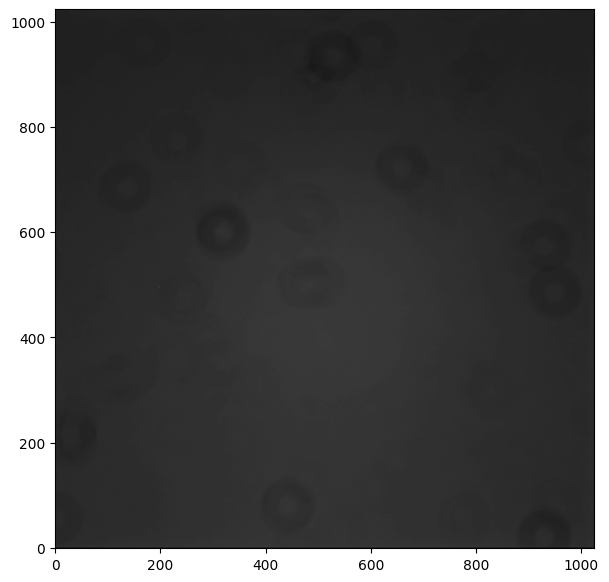

In [35]:
#get list of filepaths to use. Note the unfortunate machine dependence
imaging_flat_path_list = [r"C:\Users\tdavd\Documents\Group 2 Data\Photometry\flats\flat_0.3s_exposure_.0000000" + 
                  str(j) + r".FLAT.FIT" for j in range(10)]

#make + save master flat
master_imaging_flat_array = median_combine(fits_data_to_3d_array(imaging_flat_path_list))
save_array_as_fits(master_imaging_flat_array,'master_imaging_flat.fits')

#For a preliminary viewing:
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(master_imaging_flat_array,origin='lower',cmap='gray')

The central bright spot's pixels see about 26200-26400 counts. The darkest large regions are top corners, which receive about 24400-24600 counts per pixel. An apparent superposition of dust rings in the upper middle shows only about 24000 counts per pixel.

In [39]:
mflat_ratio = 24500./26300.
mag_change = -2.5*np.log10(mflat_ratio)
print(f"A star's magnitude would change by about {mag_change:.2f} moving from the center to an upper corner.")

A star's magnitude would change by about 0.08 moving from the center to an upper corner.


Optimal parameters: [a  mean  stdev] = [  20. 1000.   20.]


C:\Users\tdavd\AppData\Local\Temp\ipykernel_179484\1178686041.py:30: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(scaled_normal_dist, xdata=hist_x_vals, ydata=hist_y_vals, p0=[20,1000,20])


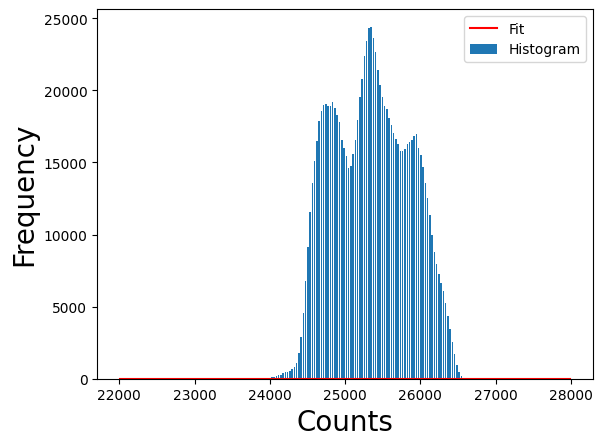

In [50]:
graph_histogram_gaussian_fit(master_imaging_flat_array.flatten(),200,[22000,28000],width=20) #this function needs revising

In [60]:
(master_imaging_flat_array < 18000).sum() #counts how many by adding Trues as 1s. The dead counting method can be revised to reveal their location.

np.int64(0)

## 4.4.1 - 4.4.4 (Anthony)

In [26]:
#Function List

# New File List Function
def create_file_list(data_directory, file_name, frame_type, num_of_files, show_list = False):
    
    '''
    This creates a list of all FITS files that will be used.
    
    Parameters:
    data_directory : path to data folder
    file_name : name of file containing data (ex.: spectrograph_flats_20s_)
                Remove anything that comes after the number!
    frame_type : type of frame saved (ex.: .FLAT, .DARK, .BIAS)
    num_of_files : number of files 
    '''
    
    file_list = [os.path.join(data_directory, file_name + f'.0000000{i}' + frame_type + '.FIT') for i in range(num_of_files)]

    
    if show_list: 
        for file in file_list: print(file)
    
    return file_list


#Adapting Trevor's Function to Automatically Shape Array
def fits_data_to_3d_array(file_list): 
    for i, file in enumerate(file_list):
        with fits.open(file) as hdu:
            if i==0:  #If first iteration, create array with correct shape of data
                final_array = np.zeros((len(file_list), *hdu[0].data.shape))
            final_array[i,:,:] = hdu[0].data
    return final_array

#My function to cut images array   -- adapt to 3d 
def cut_images_array(image_array, y_pixel_min, y_pixel_max):
    lower_index = (-1) + y_pixel_min
    upper_index = (-1) + y_pixel_max
    image_array_cut = image_array[lower_index:upper_index,:]
    print(image_array_cut.shape)
    return image_array_cut

#My function to display image
def display_fit_file(image_array):
    plt.imshow(image_array, cmap='gray', origin = 'lower') #vmin, vmax
    plt.colorbar(location='top')

### 4.4.1: Determining Spectra Corresponding to $50 \mu m$ slit
The spectra corresponding to the $50 \mu m$ slit should have the highest signal-to-noise ratio in the flat frames. It should also have the lowest resolution when looking at the spectrum. 

The following segment of code displays the one of the flats here, but this can also be done with ds9.

In [11]:
#Import FITS File Locations:
flats_file_list = create_file_list(data_directory = r'C:\Users\antho\OneDrive\PHY 443\lab_1_data\Spectograph\Flats', 
          file_name = 'spectrograph_flats_20s_', frame_type = '.FLAT', num_of_files= 1, show_list=True)
spectrum_file_list = create_file_list(data_directory = r'C:\Users\antho\OneDrive\PHY 443\lab_1_data\Spectograph\lights', 
          file_name = 'spectrograph_lights_20s_', frame_type = '', num_of_files= 1, show_list=True)
#Create FITS Image Data Arrays:
flat_field_array = fits_data_to_3d_array(flats_file_list)
spectrum_array = fits_data_to_3d_array(spectrum_file_list)

C:\Users\antho\OneDrive\PHY 443\lab_1_data\Spectograph\Flats\spectrograph_flats_20s_.00000000.FLAT.FIT
C:\Users\antho\OneDrive\PHY 443\lab_1_data\Spectograph\lights\spectrograph_lights_20s_.00000000.FIT


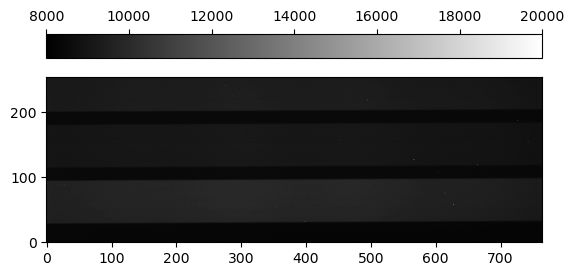

In [13]:
# Display Flat-Field
display_fit_file(flat_field_array[0])

As can be seen, the lower strip comes from the $50 \mu m$ slit. It has the highest signal to noise ratio. When viewing a the spectrum (seen below), you can also see that the lower strip has the lowest resolution spectral lines.

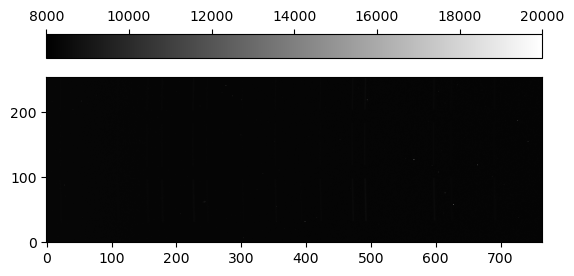

In [14]:
display_fit_file(spectrum_array[0])

### 4.4.2: Plot 1D Flat-Field Values vs Pixel Position (Along Dispersion Axis)
Steps we need to take: \
1)Cut the images to work with data only from the target $50 \mu m$ slit. \
2)Take the 2D array of the image data and find the median value of each column. This will create a 1D array with intensity values corresponding to pixel positions. \
3)Plot the 1D array vs pixel position.

(60, 765)


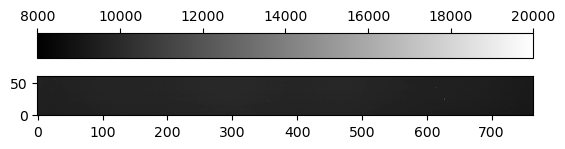

In [18]:
#Step 1

#Going into ds9, I decided to make a cut in the following range: 34 <= y <= 94
#These values correspond to the rows that will need to be cut from the flat field array.
flat_field_cut = cut_images_array(flat_field_array[0], y_pixel_min=34, y_pixel_max=94)
display_fit_file(flat_field_cut)

#np.savetxt("flat_frame_0.csv", flat_frame_0, delimiter = ",", fmt='%d')
#np.savetxt("flat_frame_0_cut.csv", flat_frame_0_cut, delimiter = ",", fmt='%d')

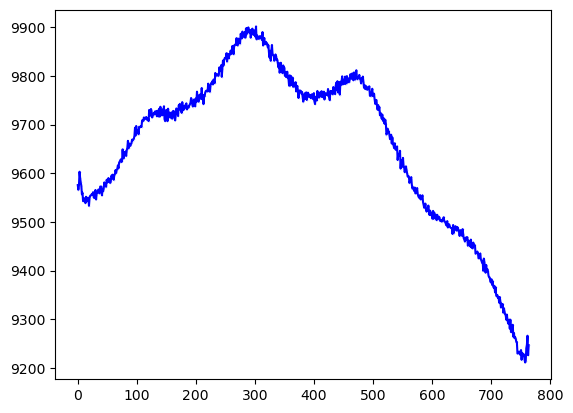

In [21]:
#Step 2
#Find the median of each column and turn into 1D array
flat_field_median = np.median(flat_field_cut, axis=0)
indices = np.arange(len(flat_field_median)) #Create 1d array of indices

#Step 3
#Plot median values vs position
plt.plot(indices, flat_field_median, marker='.', ms=0.1, linestyle='solid', color='blue')

### 4.4.3: Normalize The Flat Field

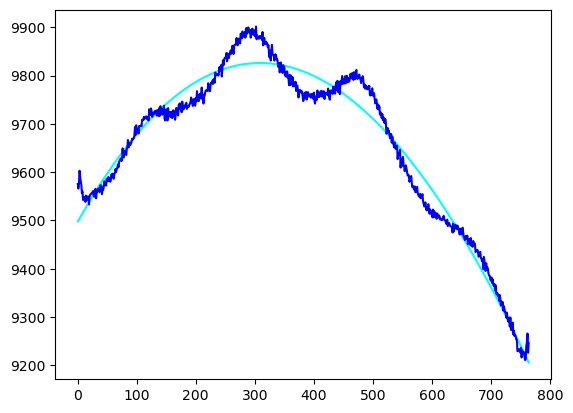

In [23]:
#Fit A Polynomial To The 1D Flat-Field Array Data
degree = 3
coefficients = np.polyfit(indices, flat_field_median, degree)

polynomial_fit = np.polyval(coefficients, indices)
polynomial_fit_2d = np.tile(polynomial_fit, (flat_field_cut.shape[0], 1))
normalized_flat_field = flat_field_cut / polynomial_fit_2d

plt.plot(indices, polynomial_fit, color='cyan')
plt.plot(indices, flat_field_median, color='blue')

np.savetxt("normalized_flat_field.csv", normalized_flat_field, delimiter = ",", fmt='%d')

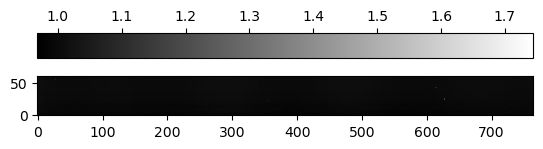

In [27]:
display_fit_file(normalized_flat_field)

### 4.4.4: Normalize The Arc Lamp Spectrum

(60, 765)


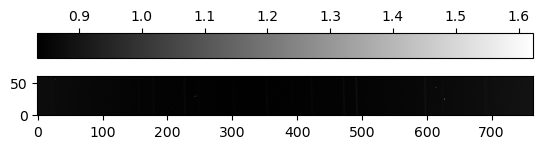

In [29]:
spectrum_array_cut = cut_images_array(spectrum_array[0], y_pixel_min=34, y_pixel_max=94)
spectrum_normalized = spectrum_array_cut / polynomial_fit_2d
display_fit_file(spectrum_normalized)

In [32]:
#Normalized Flat-Field to Fit
data_array = normalized_flat_field
hdu = fits.PrimaryHDU(data_array)
hdul = fits.HDUList([hdu])
hdul.writeto('normalized_flat_field.fit', overwrite=True)
#Normalized Spectrum to Fit
data_array = spectrum_normalized
hdu = fits.PrimaryHDU(data_array)
hdul = fits.HDUList([hdu])
hdul.writeto('normalized_spectrum.fit', overwrite=True)